# Project: Train a Quadcopter How to Fly

Designing an agent to fly a quadcopter, training it using a Deep Deterministic Policy Gradients reinforcement learning algorithm.

## Instructions

The files in the directory to better understand the structure of the project. 

- `task.py`: Define task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent provided.
    - `agent.py`: Developed agent.
- `physics_sim.py`: This file contains the simulator for the quadcopter.


In [5]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [6]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 0., 0., 0., 0.])   # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

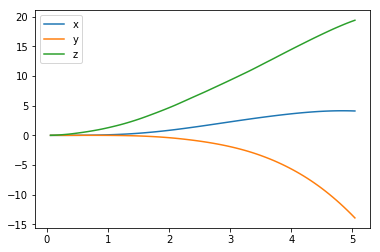

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

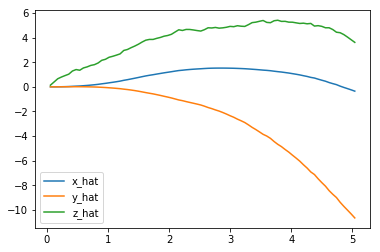

In [8]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

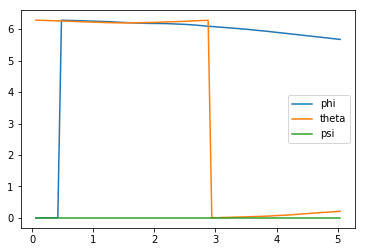

In [9]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

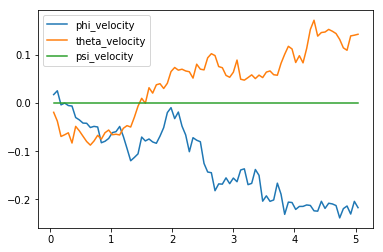

In [10]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

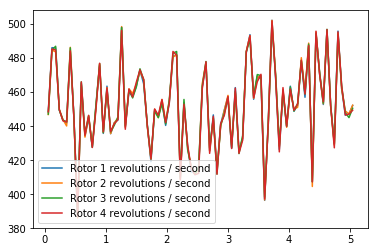

In [11]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [12]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[  4.10699896 -13.91350766  19.39534662   5.67382776   0.21094181
   0.        ]
[ -0.34983026 -10.63386261   3.60835849]
[-0.21692823  0.14199018  0.        ]


In `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [13]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 1000
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 
done = False

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode = 1000, score =  -2.680 (best =  -0.030), noise_scale = 3.25

This agent should perform very poorly on this task. We can improve this in the following cells.

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.


## Task: Take_Off 

This task is designed to elevate the quadcopter agent to a target of 20. 

In [41]:
%load_ext autoreload
%autoreload 2

import csv
import sys
import numpy as np
import pandas as pd
from agents.agent import DDPG
from task import TakeOff_Task

# Quadcopter a different starting position.
    
# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 0., 0., 0., 0.])   # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data_takeoff.txt'                 # file name for saved results

# Setup
num_episodes = 500
target_pos = np.array([0., 0., 20.])
task = TakeOff_Task(init_pose, init_velocities, init_angle_velocities, runtime, target_pos)
agent = DDPG(task)
done = False

# Labels
reward_labels = ['episode', 'total_reward']
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']

# Results
results = {x : [] for x in labels}
reward_results = {x : [] for x in reward_labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    for i_episode in range(1, num_episodes+1):
        state = agent.reset_episode() # start a new episode
        while True:
            action = agent.act(state) 
            next_state, reward, done = task.step(action)
            agent.step(action, reward, next_state, done)
            state = next_state
            rotor_speeds = agent.act(state)
            _, _, _ = task.step(rotor_speeds)
            to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
            for ii in range(len(labels)):
                results[labels[ii]].append(to_write[ii])
                writer.writerow(to_write)
                print("\rEpisode = {:4d}, best = {:7.3f}, total reward = {:7.3f}".format(
                    i_episode, agent.best_score, agent.total_reward), end="")
            if done:
                break
                
        reward_results['episode'].append(i_episode)
        reward_results['total_reward'].append(agent.total_reward)
        
        sys.stdout.flush()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode =  500, best =  -6.299, total reward =  -6.3001

## Plot the Rewards

Now that we are satisfied with the performance, we plot the episode rewards, either from a single run, or averaged over multiple runs. 

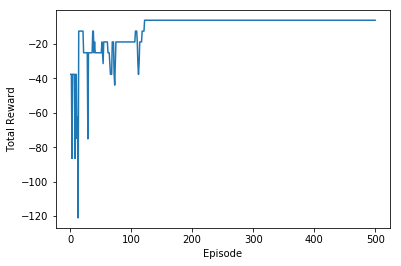

In [42]:
episode = reward_results['episode']
total_reward = reward_results['total_reward']

plt.plot(episode, total_reward)
plt.xlabel('Episode')
plt.ylabel('Total Reward');

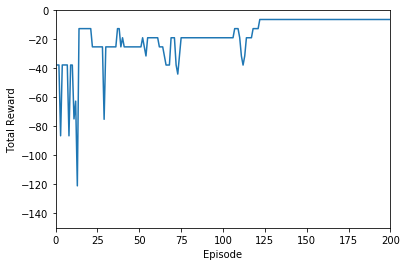

In [43]:
#Lets zoom in on the episode rewards by changing the x-axis limits
episode = reward_results['episode']
total_reward = reward_results['total_reward']
plt.plot(episode, total_reward)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
ax = plt.gca()
ax.set_xlim([0,200])
ax.set_ylim([-150,0]);

In [44]:
mean = np.mean(reward_results['total_reward'][-10:])
print("The mean reward over the last 10 episodes is: ",mean)
mean = np.mean(reward_results['total_reward'][:10])
print("The mean reward over the first 10 episodes is: ",mean)

The mean reward over the last 10 episodes is:  -6.3
The mean reward over the first 10 episodes is:  -47.45063391890701


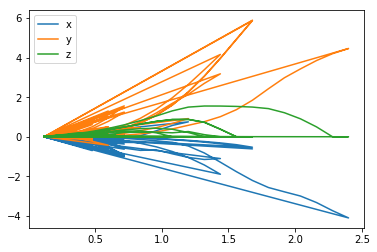

In [45]:
# visualize how the position of the quadcopter evolved during the simulation
plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

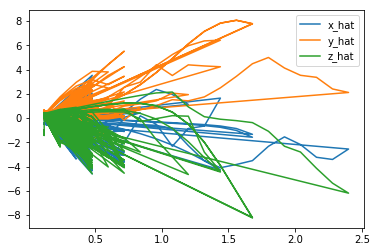

In [46]:
# visualizes the velocity of the quadcopter.
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

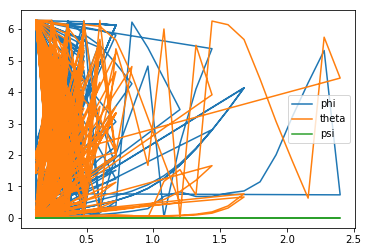

In [47]:
# Below the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes)
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

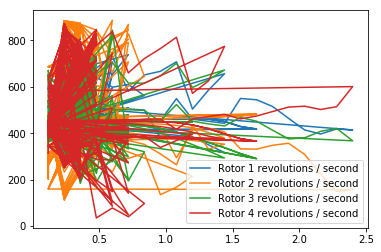

In [48]:
# agent's actions choices
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:  I created a take off task (Task_TakeOff) to reach an elevation goal of 20.  I wanted to design a simple reward function.  I initially decided to base the function on stability of the quadcopter agent and its distance from the starting point to the target goal.  The level of instability was determined by summing the absolute values of the three eigenvalues representing roll, pitch and yaw.  Since these are all deviations from zero, I penalized the agent based on the amount of instablity.  To determine the distance I used the standard formula to determine the distance between two points in three-dimensional space.  I again penalized the agent based on the distance away from the goal and added bonuses for going beyond the goal.  My original plan was to add these two penalties together and return the combined amount as a negative reward.  I decided to use negative rewards to encourage the agent to end the episode quickly.  However, I eventually commented out the instablity portion of the reward function as it seemed not to make a difference.

**Update upon resubmission**: `Based on review feedback I altered the reward function so that it would fluctuate between postive and negative rewards, rather than return only negative rewards.  The reward function still considers the distance from target but also gives large postive bonuses for exceeding the goal and large negative penalties for running out of time.`

### **Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?

- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?

- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:  I used DDPG and based my solution on the provided code. The bulk of my changes were confined to the reward function and the network architecture. I did not attempt any other algorithms. I set the learning_rate = 0.0001 (actor) and 0.001 (critic) and the regularizer_rate = 0.000005.  For the Ornstein–Uhlenbeck Noise process I used the values of mu=.02, theta=0.6 and sigma=0.2.  I left gamma and tau at their default values of .99 and .01.  For my neural network I used two dense layers with ‘relu’ activation and 512 & 256 units respectively, with L2 regularizers at .00005 separated by batch normalization layers.  I used a dropout layer in the actor (policy) network that maps states to actions with a dropout_rate = 0.02.




**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**: The take off task was relatively easy to learn once I developed a good reward function and network architecture.  The reward function appeared to have much greater impact on the **_ overall ability_** to learn than did the network architecture, whereas the network architecture seemed to impact the **_speed_** or rather the number of episodes required for learned.  There was a gradual learning curve.  My agent eventually was able to learn within an average of about 100 episodes. In some cases in as few as 50 episodes.  The mean rewards of the first/last 10 episodes are computed and noted above.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**: The most difficult part for me was getting started.  First, the provide code was object oriented in nature.  It took some time to understand the structure of the code because I had not encountered object orient python code prior to this lesson. This made the code difficult to follow.  I also had no domain knowledge with respond to flying, so I had not context on which to understand terms such as “pose”, angular velocity, etc. I was forced to do a lot of reading simply to understand a quadcopter and how one works. .  Finally, the instruction on Reinforcement Learning was the most difficult to understand when compared to the previous ML sections.  While all previous lessons provided the underlying mathematical context, the RL sections and algorithms relied heavily on mathematical notation.  It was extremely difficult to read and understand them.  I would have enjoyed a more visually simulation in order to “see” how the changes to the tasks/agent impacted the agent as opposed to trying to decent those changes based on numbers and charts.   I thing I found interesting is the differnce between subsequent executions of the workbook. In most cases the agent learns quickly and the rewards stabalize and remain relatively constant for the remaining epeisides.  But, in some instances the rewards seem to decline for a number of episodes after a period where rewards were constant.


